# Setup

In [104]:
!pip install wordcloud


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import  Counter
from wordcloud import WordCloud, STOPWORDS
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [106]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Program

## Load Data

In [107]:
train_data = pd.read_csv("https://raw.githubusercontent.com/IndoNLP/indonlu/refs/heads/master/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv", names=["text", "label"],sep = '\t') 
train_data

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [108]:
val_data = pd.read_csv("https://raw.githubusercontent.com/IndoNLP/indonlu/refs/heads/master/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv" , names=["text", "label"],sep = '\t')
val_data

,text,label
0,"meski masa kampanye sudah selesai , bukan bera...",neutral
1,tidak enak,negative
2,restoran ini menawarkan makanan sunda . kami m...,positive
3,lokasi di alun alun masakan padang ini cukup t...,positive
4,betapa bejad kader gerindra yang anggota dprd ...,negative
...,...,...
1255,"film tncfu , tidak cocok untuk penonton yang t...",negative
1256,"indihome ini mahal loh bayar nya . hanya , pen...",negative
1257,"be de gea , cowok cupu yang takut dengan pacar...",negative
1258,valen yang sangat tidak berkualitas . konentat...,negative


## EDA

In [109]:
train_data["text"][0]

'warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !'

Text(0, 0.5, 'Number of Texts')

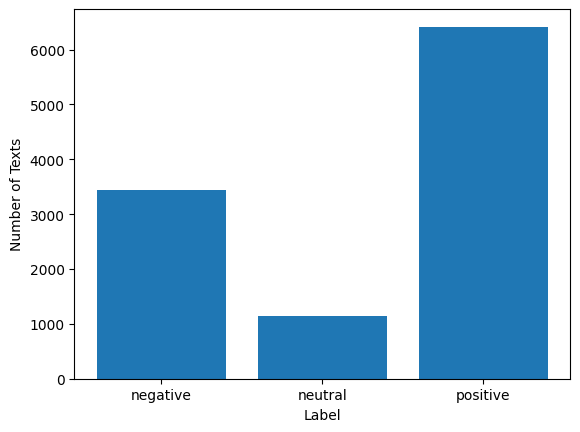

In [110]:
train_data_count = train_data.groupby('label').count()
plt.bar(train_data_count.index.values, train_data_count["text"])
plt.xlabel('Label')
plt.ylabel('Number of Texts')

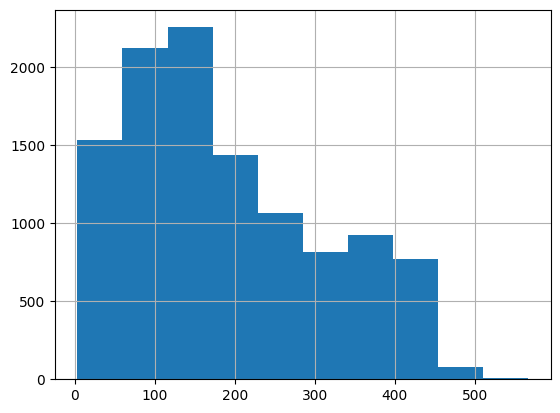

In [111]:
train_data["text"].str.len().hist()
plt.show()

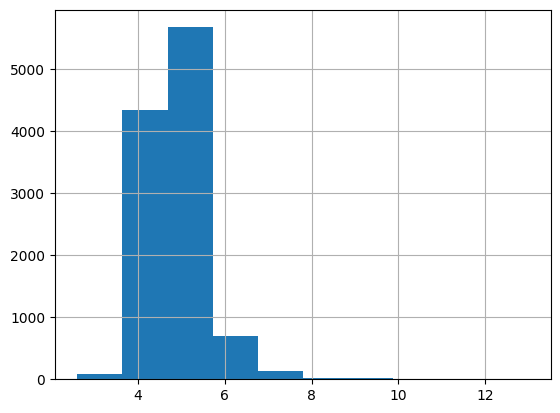

In [112]:
train_data['text'].str.split() \
    .apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

plt.show()

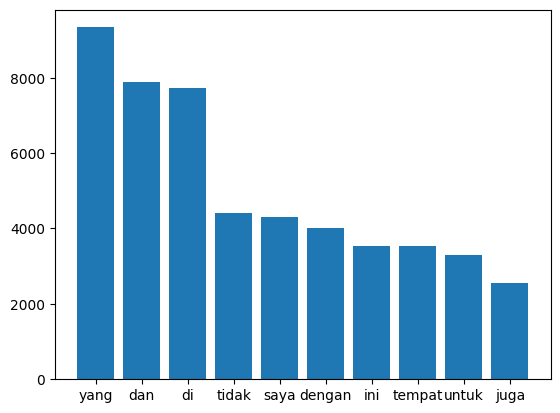

In [113]:
corpus=[]
data = train_data['text'].str.split()
data = data.values.tolist()
corpus=[word for i in data for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)
plt.show()

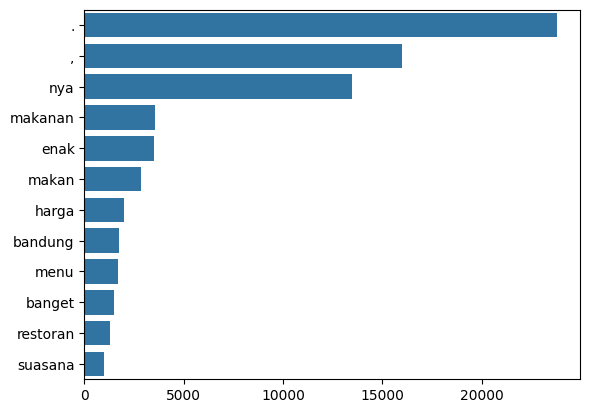

In [114]:
data= train_data["text"].str.split()
data=data.values.tolist()
corpus=[word for i in data for word in i]

counter=Counter(corpus)
most=counter.most_common()
x, y=[], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)
plt.show()

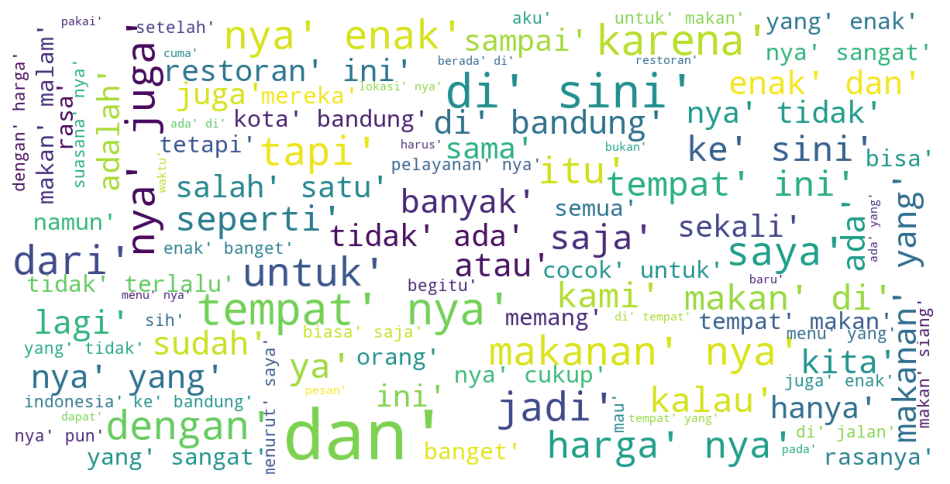

In [115]:
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

## Preprocessing

### Case folding

#### Convert text to lowercase

In [116]:
def convert_to_lowercase(df: pd.DataFrame):
    df["text"] = df["text"].apply(lambda text: text.lower())
    return df

#### Remove number

In [117]:
def remove_number(df: pd.DataFrame):
    df["text"] = df["text"].apply(lambda text: re.sub(r"\d+", "", text))
    return df

#### Remove punctuation

In [118]:
def remove_punctuation(df: pd.DataFrame):
    df["text"] = df["text"].apply(lambda text: text.translate(str.maketrans("","", string.punctuation)))
    return df

#### Remove whitespace

In [119]:
def remove_whitespace(df: pd.DataFrame):
    df["text"] = df["text"].apply(lambda text: text.strip())
    return df

In [120]:
def case_folding(df: pd.DataFrame):
    df = convert_to_lowercase(df)
    df = remove_number(df)
    df = remove_punctuation(df)
    df = remove_whitespace(df)
    return df

In [121]:
train_data = case_folding(train_data)
val_data = case_folding(val_data)

### Remove Stop word 

In [122]:
def remove_stopwords(df: pd.DataFrame):
    # According to the bar plot, we will remove word "nya" as it was a reference
    df["text"] = df["text"].apply(lambda text: text.replace(" nya", ""))
    return df

In [123]:
train_data = remove_stopwords(train_data)
val_data = remove_stopwords(val_data)

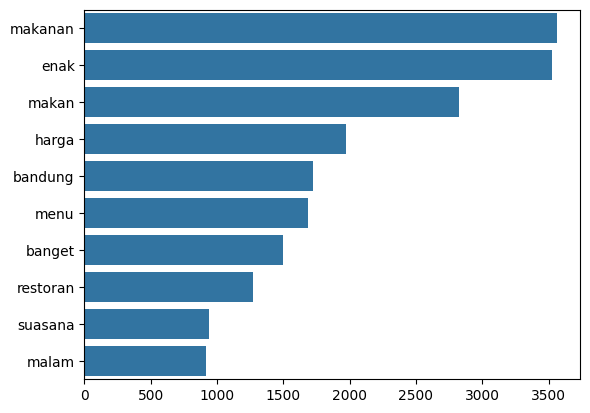

In [124]:
data= train_data["text"].str.split()
data=data.values.tolist()
corpus=[word for i in data for word in i]

counter=Counter(corpus)
most=counter.most_common()
x, y=[], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)
plt.show()

## Feature Extraction

In [125]:
# Creating the Bag of Words model
vectorizer = CountVectorizer()
train_text_counts = vectorizer.fit_transform(train_data["text"])
val_text_counts = vectorizer.transform(val_data["text"])

In [126]:
train_text_counts

<11000x17527 sparse matrix of type '<class 'numpy.int64'>'
	with 260480 stored elements in Compressed Sparse Row format>

In [127]:
val_text_counts

<1260x17527 sparse matrix of type '<class 'numpy.int64'>'
	with 28565 stored elements in Compressed Sparse Row format>

## Modeling

### Split Data

In [128]:
X_train, y_train = train_text_counts, train_data["label"]
X_val, y_val = val_text_counts, val_data["label"]

### Multinomial Naive Bayes

In [129]:
mnb_clf = MultinomialNB().fit(X_train, y_train)
prediction_mnb = mnb_clf.predict(X_val)
print(classification_report(y_val, prediction_mnb, target_names=y_train.unique()))


              precision    recall  f1-score   support

    positive       0.76      0.86      0.81       394
     neutral       0.91      0.60      0.72       131
    negative       0.90      0.90      0.90       735

    accuracy                           0.85      1260
   macro avg       0.86      0.78      0.81      1260
weighted avg       0.86      0.85      0.85      1260



In [130]:
print(accuracy_score(y_val, prediction_mnb))

0.8539682539682539


### SVM

In [131]:
svm_clf = SVC().fit(X_train, y_train)
prediction_svm = svm_clf.predict(X_val)
print(classification_report(y_val, prediction_svm, target_names=y_train.unique()))

              precision    recall  f1-score   support

    positive       0.79      0.86      0.83       394
     neutral       0.80      0.70      0.75       131
    negative       0.92      0.90      0.91       735

    accuracy                           0.87      1260
   macro avg       0.84      0.82      0.83      1260
weighted avg       0.87      0.87      0.87      1260



In [132]:
print(accuracy_score(y_val, prediction_svm))

0.8682539682539683


### Decision Tree

In [133]:
tree_clf = DecisionTreeClassifier().fit(X_train, y_train)
prediction_tree = tree_clf.predict(X_val)
print(classification_report(y_val, prediction_tree, target_names=y_train.unique()))

              precision    recall  f1-score   support

    positive       0.67      0.73      0.70       394
     neutral       0.64      0.59      0.61       131
    negative       0.88      0.85      0.87       735

    accuracy                           0.79      1260
   macro avg       0.73      0.72      0.73      1260
weighted avg       0.79      0.79      0.79      1260



### Random Forest

In [134]:
rf_clf = RandomForestClassifier().fit(X_train, y_train)
prediction_rf = rf_clf.predict(X_val)
print(classification_report(y_val, prediction_rf, target_names=y_train.unique()))

              precision    recall  f1-score   support

    positive       0.79      0.82      0.80       394
     neutral       0.91      0.57      0.70       131
    negative       0.90      0.94      0.92       735

    accuracy                           0.86      1260
   macro avg       0.87      0.78      0.81      1260
weighted avg       0.87      0.86      0.86      1260



### KNN

In [135]:
knn_clf = KNeighborsClassifier().fit(X_train, y_train)
prediction_knn = knn_clf.predict(X_val)
print(classification_report(y_val, prediction_knn, target_names=y_train.unique()))

              precision    recall  f1-score   support

    positive       0.47      0.63      0.54       394
     neutral       0.23      0.08      0.12       131
    negative       0.72      0.66      0.69       735

    accuracy                           0.59      1260
   macro avg       0.47      0.46      0.45      1260
weighted avg       0.59      0.59      0.58      1260



## Error Analysis

In [141]:
# Error analysis using svm prediction, as it gives the best result
val_data["pred"] = prediction_svm
error_predictions = val_data[val_data["pred"]!=val_data["label"]]
error_predictions

,text,label,pred
0,meski masa kampanye sudah selesai bukan berat...,neutral,negative
22,senang pakai kartu,positive,neutral
24,kalau subscriber youtube netmediatama mencapai...,neutral,negative
26,kalau melihat desain pixel sih biasa saja ta...,positive,negative
29,salut,positive,neutral
...,...,...,...
1197,tidak aib,positive,negative
1198,sebenarnya makanan steak di sini sangat enak d...,negative,positive
1200,ada yang membandingkan antara jakarta dan kota...,negative,positive
1231,aku banyak diblokir fpi buat aplikasi baru pe...,neutral,negative


In [157]:
sample_error = error_predictions.sample(5)
sample_error

,text,label,pred
915,kalau ingin sukses harus kerja keras,neutral,negative
365,barang sudah diantar ke rumah tapi rumah lagi...,neutral,negative
388,mari terus upayakan perubahan perubahan ke ar...,positive,negative
100,tidak iri,positive,negative
689,kalau fpi boikot semua medsos maka dunia medso...,positive,negative


In [160]:
for index, row in sample_error.iterrows():
    print(f"Index: {index}")
    print(f"Text: {row['text']}, Label: {row['label']}, Prediction: {row['pred']}")

Index: 915
Text: kalau ingin sukses harus kerja keras, Label: neutral, Prediction: negative
Index: 365
Text: barang sudah diantar ke rumah  tapi rumah lagi kosong, Label: neutral, Prediction: negative
Index: 388
Text: mari terus upayakan perubahan  perubahan ke arah yang lebih baik tentunya  moeldoko, Label: positive, Prediction: negative
Index: 100
Text: tidak iri, Label: positive, Prediction: negative
Index: 689
Text: kalau fpi boikot semua medsos maka dunia medsos akan menemukan kedamaian kembali  jadi mari kita dukung mereka, Label: positive, Prediction: negative
